In [1]:
from tqdm import tqdm ,trange# for progress bar 
import os,sys,requests 
from concurrent.futures import ProcessPoolExecutor ,as_completed # Asynchronous Execution
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import re
from pprint import pprint 


import torch
from torch import nn
import torch.nn.functional  as F
from torch.utils.data import Dataset , DataLoader

import torchvision
from torchvision import transforms ,models

In [2]:
!unzip Birds.zip
!ls -l Birds

Archive:  Birds.zip
   creating: Birds/
  inflating: Birds/Asian Paradise Flycatcher.csv  
  inflating: Birds/Himalayan Monal.csv  
  inflating: Birds/Indian Pitta.csv  
  inflating: Birds/Mrs. Gould’s Sunbird.csv  
  inflating: Birds/Oriental Dwarf Kingfisher.csv  
  inflating: Birds/Red Headed Trogon.csv  
  inflating: Birds/Sarus Crane.csv   
  inflating: Birds/Satyr Tragopan.csv  
  inflating: Birds/parrot.csv        
  inflating: Birds/peacock.csv       
total 620
-rw-rw-r-- 1 ubuntu ubuntu 61740 Nov  3  2018 'Asian Paradise Flycatcher.csv'
-rw-rw-r-- 1 ubuntu ubuntu 48812 Nov  3  2018 'Himalayan Monal.csv'
-rw-rw-r-- 1 ubuntu ubuntu 60080 Nov  3  2018 'Indian Pitta.csv'
-rw-rw-r-- 1 ubuntu ubuntu 54367 Nov  3  2018 'Mrs. Gould’s Sunbird.csv'
-rw-rw-r-- 1 ubuntu ubuntu 59841 Nov  3  2018 'Oriental Dwarf Kingfisher.csv'
-rw-rw-r-- 1 ubuntu ubuntu 55118 Nov  3  2018 'Red Headed Trogon.csv'
-rw-rw-r-- 1 ubuntu ubuntu 58170 Nov  3  2018 'Sarus Crane.csv'
-rw-rw-r-- 1 ubuntu ubuntu 514

In [3]:
def download_url(url:str, dest:str, overwrite:bool=False, chunk_size=1024*1024, timeout=4):
    "Download `url` to `dest` unless it exists and not `overwrite`."
    if os.path.exists(dest) and not overwrite: return

    u = requests.get(url, stream=True, timeout=timeout)
    try: file_size = int(u.headers["Content-Length"])
    except: pass
        
    with open(dest, 'wb') as f:
        for chunk in u.iter_content(chunk_size=chunk_size):
            f.write(chunk)

def download_images(urls:str, dest:Path, max_pics:int=1000, max_workers:int=8, timeout=4,prefix=None,show_progress=True):
    "Download images listed in text file urls to path dest , at most max_pics"
    urls = open(urls).read().strip().split("\n")[:max_pics] # get all the urls in the list
    dest = Path(dest) # get the path of the folder 
    dest.mkdir(exist_ok=True) # create all the parent and child directory if neccessary. 

    if max_workers: # use the power of multiprocessing
        with ProcessPoolExecutor(max_workers=max_workers) as ex: # use a ProcessPoolExecutor for using pool of process to execute call asynchronously.
             # submit schedules the callable and return a Future object on completion. We iterate through all the urls to create Future objects for each url 
            futures = [ex.submit(download_url, url, dest/f"{i:08d}.jpg", timeout=timeout) for i,url in enumerate(urls)]
            if show_progress : 
                for f in tqdm(as_completed(futures), total=len(urls),desc=prefix): pass # show th progress bar

In [4]:
# get the path for all csv files
birdspath = Path("Birds")
birdspath = [ Path(child) for child in birdspath.iterdir()]
birdspath

[PosixPath('Birds/Himalayan Monal.csv'),
 PosixPath('Birds/Red Headed Trogon.csv'),
 PosixPath('Birds/Mrs. Gould’s Sunbird.csv'),
 PosixPath('Birds/Oriental Dwarf Kingfisher.csv'),
 PosixPath('Birds/Indian Pitta.csv'),
 PosixPath('Birds/Sarus Crane.csv'),
 PosixPath('Birds/Asian Paradise Flycatcher.csv'),
 PosixPath('Birds/Satyr Tragopan.csv'),
 PosixPath('Birds/parrot.csv'),
 PosixPath('Birds/peacock.csv')]

In [5]:
all_birds_Name = [re.sub(r".csv|\.\s|\s*|\’" , r"", x.name) for x in birdspath] # Get all the birds name from the csv file
pprint(all_birds_Name)
folder_file = {x:y for x ,y in zip(all_birds_Name , birdspath)} # create a folder name the file name dictionary 
pprint(folder_file)

['HimalayanMonal',
 'RedHeadedTrogon',
 'MrsGould’sSunbird',
 'OrientalDwarfKingfisher',
 'IndianPitta',
 'SarusCrane',
 'AsianParadiseFlycatcher',
 'SatyrTragopan',
 'parrot',
 'peacock']
{'AsianParadiseFlycatcher': PosixPath('Birds/Asian Paradise Flycatcher.csv'),
 'HimalayanMonal': PosixPath('Birds/Himalayan Monal.csv'),
 'IndianPitta': PosixPath('Birds/Indian Pitta.csv'),
 'MrsGould’sSunbird': PosixPath('Birds/Mrs. Gould’s Sunbird.csv'),
 'OrientalDwarfKingfisher': PosixPath('Birds/Oriental Dwarf Kingfisher.csv'),
 'RedHeadedTrogon': PosixPath('Birds/Red Headed Trogon.csv'),
 'SarusCrane': PosixPath('Birds/Sarus Crane.csv'),
 'SatyrTragopan': PosixPath('Birds/Satyr Tragopan.csv'),
 'parrot': PosixPath('Birds/parrot.csv'),
 'peacock': PosixPath('Birds/peacock.csv')}


In [6]:
for folder,file in folder_file.items():
    path = Path("train") # create a parent directory   
    dest = path/folder # Specific folder for each bird
    dest.mkdir(parents=True,exist_ok=True)
    download_images(file, dest,prefix=folder,max_workers=16)

peacock: 100%|██████████| 810/810 [00:45<00:00,  3.62s/it]


In [7]:
length = lambda iterrator : len(tuple(iterrator))
birdsPerClassCount = { (path/folder).name : length((path/folder).iterdir()) for folder,file in folder_file.items() }
sorted(birdsPerClassCount.items() , key=lambda x :x[1])

[('HimalayanMonal', 500),
 ('SatyrTragopan', 530),
 ('OrientalDwarfKingfisher', 532),
 ('MrsGould’sSunbird', 543),
 ('RedHeadedTrogon', 577),
 ('SarusCrane', 601),
 ('AsianParadiseFlycatcher', 627),
 ('IndianPitta', 635),
 ('peacock', 796),
 ('parrot', 823)]

In [8]:
import PIL
def verify_image(file:Path, delete:bool ,dest:Path=None, n_channels:int=3, **kwargs):
    """Check if the image in `file` exists, can be opend and has `n_channels`. If `delete`, removes it if it fails.
        Result is stored in `dest` `img_format` and `kwargs` are passed to PIL.Image.save."""
    try:
        img = PIL.Image.open(file)
        assert isinstance(dest, Path), "You should provide `dest` Path to save resized image"
        if not file.is_file(): return
        if n_channels == 3: img = img.convert("RGB")
        img.save(file, **kwargs)
        img = np.array(img)
        img_channels = 1 if len(img.shape) == 2 else img.shape[2]
        assert img_channels == n_channels, f"Image {file} has {img_channels} instead of {n_channels}"
    except Exception as e:
        #print(f'{e}')
        if delete: file.unlink()

def verify_images(path:Path, delete:bool=True, max_workers:int=4 , dest:Path=".",n_channels:int=3,**kwargs):
    """Check if the image in `path` exists, can be opened and has `n_channels`.
    If `n_channels` is 3 – it'll try to convert image to RGB. If `delete`, removes it if it fails.
    If `max_size` is specifided,
    image is resized to the same ratio so that both sizes are less than `max_size`, using `interp`.
    Result is stored in `dest`, `ext` forces an extension type, `img_format` and `kwargs` are
    passed to PIL.Image.save. Use `max_workers` CPUs."""
    dest = path/Path(dest)
    dest.mkdir(exist_ok=True)
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        files = [Path(file) for file in path.iterdir()]
        futures = [ex.submit(verify_image, file, delete=delete,dest=dest, n_channels=n_channels, **kwargs) for file in files]
    for f in tqdm(as_completed(futures), total=len(files) , desc=path.name): pass
    


In [9]:
for folder,file in folder_file.items():
    path = Path("train")
    verify_images(path/folder,delete=True)

HimalayanMonal: 100%|██████████| 500/500 [00:00<00:00, 232319.93it/s]
/home/ubuntu/instoried/lib/python3.6/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
RedHeadedTrogon: 100%|██████████| 577/577 [00:00<00:00, 238528.82it/s]
/home/ubuntu/instoried/lib/python3.6/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
OrientalDwarfKingfisher: 100%|██████████| 532/532 [00:00<00:00, 232968.23it/s]
/home/ubuntu/instoried/lib/python3.6/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/instoried/lib/python3.6/site-packages/PIL/Image.py:993: Use

In [10]:
birdsPerClassCountVerify = { (path/folder).name :len([*(path/folder).iterdir()]) for folder,file in folder_file.items() }
sorted(birdsPerClassCountVerify.items() , key=lambda x :x[1])

[('HimalayanMonal', 442),
 ('SatyrTragopan', 474),
 ('OrientalDwarfKingfisher', 475),
 ('MrsGould’sSunbird', 493),
 ('RedHeadedTrogon', 513),
 ('IndianPitta', 546),
 ('SarusCrane', 549),
 ('AsianParadiseFlycatcher', 560),
 ('parrot', 709),
 ('peacock', 729)]

In [11]:
batch_size=128*torch.cuda.device_count()
transform = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
myDataset = torchvision.datasets.ImageFolder("train" , transform = transform)
valid_no  = int(0.2 * len(myDataset))
# so divide the data into trainset and testset
trainSet,testSet = torch.utils.data.random_split(myDataset,(len(myDataset)-valid_no,valid_no))
print(f"len of trainSet {len(trainSet)} , len of testSet {len(testSet)}")
trainLoader  = DataLoader(trainSet , batch_size=batch_size ,shuffle=True) 
testLoader  = DataLoader(testSet , batch_size=batch_size ,shuffle=True)
data_loader={"train":trainLoader , "val":testLoader}

len of trainSet 4392 , len of testSet 1098


In [66]:
model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)
## freeze the entire convolution base
for param in model.parameters():
    param.requires_grad_(False)
    
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
    features_lst = [num_features , num_features//2 , num_features//4]
    layers = []
    for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
        layers.append(nn.Linear(in_f , out_f))
        layers.append(activation_func())
        layers.append(nn.BatchNorm1d(out_f))
        if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.Linear(features_lst[-1] , number_classes))
    return nn.Sequential(*layers)

top_head = create_head(num_features , len(birdsPerClassCount)) # because ten classes
model.fc = top_head # replace the fully connected layer

2048


In [67]:
import copy
model_super_conv = copy.deepcopy(model)

In [68]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.nn.DataParallel(model).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

model_super_conv = torch.nn.DataParallel(model_super_conv).to(device)
optimizer_super_conv = optim.Adam(model_super_conv.parameters(), lr=0.01)


In [15]:
from tqdm import trange

def train(model , data_loader , criterion , optimizer , num_epochs=5):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
      else:     # put the model in validation mode
        model.eval()
       
      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0  
      
      for data , target in data_loader[phase]:
        #load the data and target to respective device
        data , target = data.to(device)  , target.to(device)

        with torch.set_grad_enabled(phase=="train"):
          #feed the input
          output = model(data)
          #calculate the loss
          loss = criterion(output,target)
          preds = torch.argmax(output,1)

          if phase=="train"  :
            # backward pass: compute gradient of the loss with respect to model parameters 
            loss.backward()
            # update the model parameters
            optimizer.step()
            # zero the grad to stop it from accumulating
            optimizer.zero_grad()


        # statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == target.data).item()
        
        
      epoch_loss = running_loss / len(data_loader[phase].dataset)
      epoch_acc = running_corrects / len(data_loader[phase].dataset)

      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print(result)


In [16]:
train(model,data_loader , criterion, optimizer,num_epochs=10)

Epochs:  10%|█         | 1/10 [01:59<17:51, 119.04s/it]

['train Loss: 1.4076 Acc: 0.5533', 'val Loss: 7.2398 Acc: 0.4827']


Epochs:  20%|██        | 2/10 [03:38<15:06, 113.31s/it]

['train Loss: 0.6342 Acc: 0.8071', 'val Loss: 1.7492 Acc: 0.7732']


Epochs:  30%|███       | 3/10 [05:19<12:45, 109.36s/it]

['train Loss: 0.5355 Acc: 0.8372', 'val Loss: 0.8349 Acc: 0.8506']


Epochs:  40%|████      | 4/10 [06:59<10:39, 106.59s/it]

['train Loss: 0.4618 Acc: 0.8618', 'val Loss: 0.7415 Acc: 0.8434']


Epochs:  50%|█████     | 5/10 [08:39<08:43, 104.65s/it]

['train Loss: 0.4255 Acc: 0.8723', 'val Loss: 0.5552 Acc: 0.8679']


Epochs:  60%|██████    | 6/10 [10:19<06:53, 103.28s/it]

['train Loss: 0.3882 Acc: 0.8864', 'val Loss: 0.5443 Acc: 0.8561']


Epochs:  70%|███████   | 7/10 [11:59<05:07, 102.36s/it]

['train Loss: 0.3585 Acc: 0.8925', 'val Loss: 0.5390 Acc: 0.8588']


Epochs:  80%|████████  | 8/10 [13:39<03:23, 101.69s/it]

['train Loss: 0.3416 Acc: 0.8939', 'val Loss: 0.4994 Acc: 0.8679']


Epochs:  90%|█████████ | 9/10 [15:19<01:41, 101.22s/it]

['train Loss: 0.3138 Acc: 0.9064', 'val Loss: 0.5047 Acc: 0.8652']


Epochs: 100%|██████████| 10/10 [17:00<00:00, 100.92s/it]

['train Loss: 0.3032 Acc: 0.9071', 'val Loss: 0.5204 Acc: 0.8634']


In [17]:
def perClassAccuracy(model ,classes):
  class_correct = np.zeros(len(classes) ,dtype =np.int64 )
  class_total = np.zeros_like(class_correct,dtype =np.int64 )
  model.eval()
  
  for data ,target in data_loader["val"]:
    data,target =data.to(device) , target.to(device)
    with torch.set_grad_enabled(False):
      output =model(data)
      preds = torch.argmax(output,1)
      for prediction , label in zip(preds , target.data):
        if prediction == label:
          class_correct[prediction]+=1
        class_total[label]+=1
  per = np.round((100*class_correct/class_total) ,4)
  out = "\n".join([f"{name} :- {acc} %" for name ,acc in zip(classes , per)])
  return out+"\ntotal acc is {0}%".format(100* sum(class_correct)/sum(class_total))

print(perClassAccuracy(model , myDataset.classes))

AsianParadiseFlycatcher :- 88.2883 %
HimalayanMonal :- 77.1739 %
IndianPitta :- 80.0 %
MrsGould’sSunbird :- 79.7872 %
OrientalDwarfKingfisher :- 89.011 %
RedHeadedTrogon :- 77.0833 %
SarusCrane :- 92.233 %
SatyrTragopan :- 89.1892 %
parrot :- 96.3768 %
peacock :- 87.6543 %
total acc is 86.33879781420765%


In [69]:
def unfreeze(model,percent=0.25):
  l = int(np.ceil(len(model.module._modules.keys())* percent))
  l = list(model.module._modules.keys())[-l:]
  print(f"unfreezing these layer {l}",)
  for name in l:
    for params in model.module._modules[name].parameters():
      params.requires_grad_(True)

def check_freeze(model):
  for name ,layer in model.module._modules.items():
    s = []
    for l in layer.parameters():
      s.append(l.requires_grad)
    print(name ,all(s))
# unfreeze half of the model
unfreeze(model_super_conv ,0.30)
# check which layer is freezed or not
check_freeze(model_super_conv)

unfreezing these layer ['layer4', 'avgpool', 'fc']
conv1 False
bn1 False
relu True
maxpool True
layer1 False
layer2 False
layer3 False
layer4 True
avgpool True
fc True


In [38]:
from torch.optim import lr_scheduler
class LinearScheduler(lr_scheduler._LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of iterations."""
    def __init__(self, optimizer, end_lr, num_iter):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearScheduler,self).__init__(optimizer)

    def get_lr(self):
        # increement one by one
        curr_iter = self.last_epoch + 1
        # get the ratio
        pct = curr_iter / self.num_iter
        # calculate lr with this formulae start + pct * (end-start)
        return [base_lr + pct * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialScheduler(lr_scheduler._LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of iterations."""

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialScheduler,self).__init__(optimizer)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        pct = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** pct for base_lr in self.base_lrs]
      
class CosineScheduler(lr_scheduler._LRScheduler):
    """Cosine increases the learning rate between two boundaries over a number of iterations."""

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(CosineScheduler,self).__init__(optimizer)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        pct = curr_iter / self.num_iter
        cos_out = np.cos(np.pi * pct) + 1
        return [self.end_lr + (base_lr - self.end_lr )/2 *cos_out for base_lr in self.base_lrs]

In [70]:
class LRFinder:
  
  def __init__(self, model  , optimizer , criterion ,start_lr=1e-7, device=None):
    
    self.model = model
    # Move the model to the proper device
    self.optimizer = optimizer
    self.criterion = criterion
    
    ## save the model intial dict
    self.save_file = Path("tmpfile")
    torch.save(self.model , self.save_file)    
    if device is None:
      self.device = next(model.parameters()).device
    else:
      self.device = device
    self.model.to(self.device)
    
    self.history = {"lr":[] , "losses":[]}
    for l in self.optimizer.param_groups:
      l["initial_lr"]=start_lr
    
    
  def reset(self):
    """ Resets the model to intial state """
    self.model = torch.load(self.save_file)
    self.model.train()
    self.save_file.unlink()
    return self.model
    
  def calculateSmmothingValue(self ,beta):
    n ,mov_avg=0,0
    while True :
      n+=1
      value = yield
      mov_avg = beta*mov_avg +(1-beta)*value
      smooth = mov_avg / (1 - beta **n )
      yield smooth
    
  def lrfind(self, trainLoader,end_lr=10,num_iter=50,step_mode="exp", loss_smoothing_beta=0.99, diverge_th=4): 
        """
         Performs the lrfind test

         Arguments:
            trainLoader : The data loader
            end_lr :  The maximum lr
            num_iter : Max iteratiom
            step_mode : The anneal function by default `exp` but can be either `linear` or `cos`
            smooth_f : The loss smoothing factor, value should be between [0 , 1[
            diverge_th: The max loss value after which training should be stooped
        """
              # Reset test results
        self.history = {"lr": [], "losses": []}
        self.best_loss = None
        self.smoothner = self.calculateSmmothingValue(loss_smoothing_beta)
        
        if step_mode.lower()=="exp":
          lr_schedule = ExponentialScheduler(self.optimizer , end_lr  , num_iter,)
        elif step_mode.lower()=="cos":
          lr_schedule = CosineScheduler(self.optimizer , end_lr  , num_iter)
        elif step.mode.lower()=="linear":
          lr_schedule = LinearScheduler(self.optimizer , end_lr  , num_iter)
        else:
          raise ValueError(f"expected mode is either {exp , cos ,linear} got {step_mode}")
        
        if 0 < loss_smoothing_beta >=1:
          raise ValueError("smooth_f is outside the range [0, 1[")
        
        iterator = iter(trainLoader)
        for each_iter in range(num_iter):
          try:
            data , target = next(iterator)
          except StopIteration:
            iterator = iter(trainLoader)
            data , target = next(iterator)
         
          loss = self._train_batch(data , target)
          
          # Update the learning rate
          lr_schedule.step()
          self.history["lr"].append(lr_schedule.get_lr()[0])
          # Track the best loss and smooth it if smooth_f is specified
          if each_iter == 0:
              self.best_loss = loss
          else:
              next(self.smoothner)
              self.best_loss = self.smoothner.send(loss)
              if loss < self.best_loss:
                  self.best_loss = loss

          # Check if the loss has diverged; if it has, stop the test
          self.history["losses"].append(self.best_loss)
          if loss > diverge_th * self.best_loss:
              print("Stopping early, the loss has diverged")
              break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")            
  
  def _train_batch(self,data,target):
    # set to training mode
    self.model.train()
    #load data to device
    data ,target = data.to(self.device) ,target.to(self.device)
    
    #forward pass
    self.optimizer.zero_grad()
    for l in self.optimizer.param_groups:
        lr =l["lr"] 
    output = self.model(data)
    loss = self.criterion(output,target)
    
    #backward pass
    loss.backward()
    self.optimizer.step()
    return loss.item()
  
  def plot(self):
    losses = self.history["losses"]
    lr = self.history["lr"]
    plt.semilogx(lr,losses)
    plt.xlabel("Learning rate")
    plt.ylabel("Losses ")


In [40]:
lr_finder = LRFinder(model_super_conv, optimizer_super_conv, criterion, device=device)
lr_finder.lrfind(data_loader["train"], end_lr=1, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


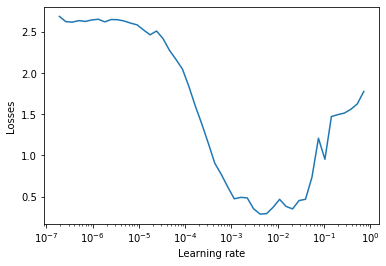

In [41]:
lr_finder.plot()

In [42]:
model_super_conv = lr_finder.reset()
optimizer_super_conv = optim.Adam(model_super_conv.parameters(), lr=0.01)


In [45]:
class Stepper():
    "Used to \"step\" from start,end (`vals`) over `n_iter` iterations on a schedule defined by `func`"
    
    def __init__(self, val, n_iter:int, func):
        self.start,self.end = val
        self.n_iter = max(1,n_iter)
        self.func = func
        self.n = 0

    def step(self):
        "Return next value along annealed schedule."
        self.n += 1
        return self.func(self.start, self.end, self.n/self.n_iter)

    @property
    def is_done(self):
        "Return `True` if schedule completed."
        return self.n >= self.n_iter
    
# Annealing functions
def annealing_no(start, end, pct):
    "No annealing, always return `start`."
    return start
  
def annealing_linear(start, end, pct):
    "Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start + pct * (end-start)
  
def annealing_exp(start, end, pct):
    "Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start * (end/start) ** pct

def annealing_cos(start, end, pct):
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out

In [71]:

class OneCyclePolicy:
  
  def __init__(self,model , optimizer , criterion ,num_iteration,num_epochs,max_lr, momentum = (0.95,0.85) , div_factor=25 , pct_start=0.4, device=None ):
    
    self.model =model
    self.optimizer = optimizer
    self.criterion = criterion
    self.num_epochs = num_epochs
    if device is None:
      self.device = next(model.parameters()).device
    else:
      self.device = device
      
    n = num_iteration * self.num_epochs
    a1 = int(n*pct_start)
    a2 = n-a1
    self.phases = ((a1 , annealing_linear) , (a2 , annealing_cos))
    min_lr = max_lr/div_factor
    self.lr_scheds = self.steps((min_lr,max_lr) , (max_lr,min_lr/1e4))
    self.mom_scheds =self.steps(momentum , momentum[::-1])
    self.idx_s = 0
    self.update_lr_mom(self.lr_scheds[0].start,self.mom_scheds[0].start)
  
  def steps(self, *steps):
      "Build anneal schedule for all of the parameters."
      return [Stepper(step, n_iter, func=func)for (step,(n_iter,func)) in zip(steps, self.phases)]

  def train(self, trainLoader , validLoader ):
    self.model.to(self.device)
    data_loader = {"train":trainLoader , "val":validLoader}
    for epoch in tqdm(range(self.num_epochs),desc="Epochs"):
      result = []
      for phase in ['train', 'val']:
        if phase=="train":     # put the model in training mode
          model.train()
        else:     # put the model in validation mode
          model.eval()

        # keep track of training and validation loss
        running_loss = 0.0
        running_corrects = 0  

        for data , target in data_loader[phase]:
          #load the data and target to respective device
          data , target = data.to(device)  , target.to(device)

          with torch.set_grad_enabled(phase=="train"):
            #feed the input
            output = self.model(data)
            #calculate the loss
            loss = self.criterion(output,target)
            preds = torch.argmax(output,1)

            if phase=="train"  :
              # backward pass: compute gradient of the loss with respect to model parameters 
              loss.backward()
              # update the model parameters
              self.optimizer.step()
              # zero the grad to stop it from accumulating
              self.optimizer.zero_grad()
            
              self.update_lr_mom(self.lr_scheds[self.idx_s].step() ,self.mom_scheds[self.idx_s].step() )

              if self.lr_scheds[self.idx_s].is_done:
                self.idx_s += 1
          
          # statistics
          running_loss += loss.item() * data.size(0)
          running_corrects += torch.sum(preds == target.data).item()


        epoch_loss = running_loss / len(data_loader[phase].dataset)
        epoch_acc = running_corrects/ len(data_loader[phase].dataset)

        result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      print(result)

  def update_lr_mom(self,lr=0.001,mom=0.99):
    for l in self.optimizer.param_groups:
      l["lr"]=lr
      if isinstance(self.optimizer , ( torch.optim.Adamax,torch.optim.Adam)):
          l["betas"] = ( mom, 0.999)
      elif isinstance(self.optimizer, torch.optim.SGD):
          l["momentum"] =mom

In [72]:
fit_one_cycle = OneCyclePolicy(model_super_conv ,optimizer_super_conv , criterion,
                               num_iteration=len(trainLoader)  , num_epochs =5 ,
                               max_lr =0.001 ,device=device)
fit_one_cycle.train(trainLoader,testLoader)

Epochs:  20%|██        | 1/5 [01:41<06:46, 101.52s/it]

['train Loss: 2.0348 Acc: 0.3179', 'val Loss: 0.7256 Acc: 0.8097']


Epochs:  40%|████      | 2/5 [03:22<05:04, 101.49s/it]

['train Loss: 0.5220 Acc: 0.8541', 'val Loss: 0.4162 Acc: 0.8834']


Epochs:  60%|██████    | 3/5 [05:04<03:22, 101.48s/it]

['train Loss: 0.2613 Acc: 0.9271', 'val Loss: 0.3958 Acc: 0.8934']


Epochs:  80%|████████  | 4/5 [06:45<01:41, 101.49s/it]

['train Loss: 0.1407 Acc: 0.9620', 'val Loss: 0.3632 Acc: 0.9044']


Epochs: 100%|██████████| 5/5 [08:27<00:00, 101.45s/it]

['train Loss: 0.0936 Acc: 0.9770', 'val Loss: 0.3751 Acc: 0.8980']


In [73]:
print(perClassAccuracy(model_super_conv , myDataset.classes))

AsianParadiseFlycatcher :- 90.991 %
HimalayanMonal :- 84.7826 %
IndianPitta :- 87.0 %
MrsGould’sSunbird :- 89.3617 %
OrientalDwarfKingfisher :- 93.4066 %
RedHeadedTrogon :- 85.4167 %
SarusCrane :- 95.1456 %
SatyrTragopan :- 91.8919 %
parrot :- 99.2754 %
peacock :- 91.358 %
total acc is 91.2568306010929%
